## **Trading Strategy**

Performed **sample runs** on the developed **quintile-based long-short trading strategy** using computed **realized and implied H values** for a selected investment period (**2010–2023**) and tickers.  

🔹 **Note:** Implied H values still need to be computed for the **entire investment universe**.

#### **For the Final Submission:**
We aim to refine and enhance the strategy by:
- 📈 **Incorporating additional features** to improve signal robustness.
  - For example:
    - Construct **long-only portfolios** across all quintiles.  
    - Explore **different long-short combinations** to optimize strategy performance. 
- 💰 **Accounting for trading costs** to reflect real market conditions.  
- 📊 **Implementing risk controls** (e.g., liquidity constraints, factor exposure adjustments).  
- 🏆 **Conducting robust and detailed backtesting** to evaluate performance, risk-adjusted returns, and strategy viability under realistic conditions, alpha generation.

#### **Objective**
The goal is to create a **realistic, well-tested, and effective trading strategy** based on volatility roughness.

In [460]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
from scipy.stats import zscore
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from datetime import timedelta as td
import statsmodels.api as sm
import random
from functools import reduce
from scipy.stats import skew, kurtosis

### **H Value Data**

In [461]:
realised_h_df = pd.read_csv(r'/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Project/buy-rough-sell-smooth/Realized_H_Data.csv')
realised_h_df.rename(columns={'Realized_H':'H_value'}, inplace=True)
realised_h_df

,date,H_value,ticker,price
0,2010-01-29,0.137720,AAPL,192.063
1,2010-02-26,0.130794,AAPL,204.620
2,2010-03-31,0.071049,AAPL,235.000
3,2010-04-30,0.137683,AAPL,261.090
4,2010-05-28,5.734701,AAPL,256.880
...,...,...,...,...
15457,2023-04-28,0.023559,XOM,118.340
15458,2023-05-31,0.016606,XOM,102.180
15459,2023-06-30,0.052514,XOM,107.250
15460,2023-07-31,0.068541,XOM,107.240


In [462]:
implied_h_df = pd.read_csv(r'/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Project/buy-rough-sell-smooth/implied_H.csv')
implied_h_df.rename(columns={'Ticker': 'ticker', 'Date': 'date', 'Price': 'price'}, inplace=True)
implied_h_df

,ticker,date,price,H_value
0,APD,2010-01-31,75.96,0.215457
1,PFE,2010-01-31,18.66,-0.378224
2,WMB,2010-01-31,20.84,-0.072494
3,DLR,2010-01-31,50.15,-0.178283
4,VZ,2010-01-31,29.33,-0.176748
...,...,...,...,...
663,GS,2023-12-31,385.77,0.186165
664,KVUE,2023-12-31,21.53,0.132487
665,ISRG,2023-12-31,337.36,0.201932
666,VZ,2023-12-31,37.70,0.393089


### **Trading Strategy Implementation**

#### **Ranking Methodology: Quintile Ranking of H_value**

The ranking process assigns each ticker a rank from 1 to 5 within each month based on its roughness using the Hurst Index (H) value:

1. **Within-Month Sorting:**  
   Tickers are ordered by their H value on each month.  
   - The ticker with the highest H value is placed at the top.
   - The ticker with the lowest H value is placed at the bottom.

2. **Quintile Assignment:**  
   The ordered list is then divided into five equally sized groups (quintiles).  
   - **Rank 1:** Tickers with the highest H values.
   - **Rank 5:** Tickers with the lowest H values.
   - Intermediate ranks indicate middle groupings.

#### **Ranking Interpretation**
Within each month, every ticker receives an integer rank from **1** to **5**:
- **Rank 1:** Represents the most favorable condition for short positions.
- **Rank 5:** Represents the most favorable condition for long positions.
- Tickers with intermediate ranks remain neutral.

---

#### **Signal Generation**

Based on the quintile rankings:
- **Short Signal:** Issued to tickers with a rank equal to the predefined short threshold (Rank 1).
- **Long Signal:** Issued to tickers with a rank equal to the predefined long threshold (Rank 5).
- **Neutral:** Tickers with intermediate ranks receive no position.

By default, the strategy assumes trading 1 share per asset, though this can be adjusted as needed.

---

#### **Trading Strategy**

1. **Rebalancing:**  
   The portfolio is rebalanced monthly. Signals are generated at month-end and applied on the following trading day.

2. **Profit/Loss Computation:**  
   - **Price Change:** The difference between the current and previous price is calculated for each ticker.
   - **PnL Calculation:** The trading signal is multiplied by the price change to compute the raw profit or loss.
   - **Short Borrow Cost:** For short positions, a monthly borrowing cost is subtracted.
   - **Position Notional:** Exposure per ticker is computed as the product of the previous period's price and the absolute value of the signal.

3. **Return Calculation:**  
   - **Monthly Return:** Calculated as the total PnL divided by the total notional exposure (capital at risk) across all positions.
   - **Cumulative Return:** Determined by compounding the monthly returns over time.

4. **Capital Scaling:**  
   The strategy evaluates performance on a consistent capital basis by normalizing returns with the aggregated notional exposure.

---

This methodology ensures that the trading strategy dynamically ranks tickers each month, generates clear long/short signals, and computes performance in a normalized, capital-adjusted manner.


In [463]:
# Modify the function to rank h_vals into quintiles per date
def rank_H_quintiles(df):
    # Ensure date column is in datetime format
    monthly = df.copy()
    monthly["date"] = pd.to_datetime(monthly["date"])
    
    # Sort values by date and h_val
    monthly = monthly.sort_values(["date", "H_value"])
    
    # Assign quintile ranks (1 to 5) based on h_val per date
    monthly["h_rank"] = (
    monthly.groupby("date")["H_value"]
    .transform(lambda x: pd.qcut(-x, q=5, labels=False, duplicates='drop') + 1)
    )
    
    # Sort final result by ticker & date
    monthly = monthly.sort_values(["ticker", "date"]).reset_index(drop=True)
    
    return monthly

In [464]:
def generate_signal(rank_val, long=5, short=1, strat="long/short"):
    """
    Example signal generator for demonstration.
    Adjust as needed for your actual logic.
    """
    if strat == "long_only":
        return 1 if rank_val == long else 0
    elif strat == "short_only":
        return -1 if rank_val == short else 0
    else:  # long/short
        if rank_val == long:
            return 1
        elif rank_val == short:
            return -1
        else:
            return 0

In [465]:
def trading_strategy(
    h_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,  # e.g. 2% annual for short positions
    trading_months_per_year=12,
    strat="long/short",
):
    # ------------------------------
    # 1) Generate Signals
    # ------------------------------
    h_df = h_df.copy()
    h_df["date"] = pd.to_datetime(h_df["date"])
    h_df = h_df.sort_values(["ticker", "date"]).reset_index(drop=True)

    # Build signals for each factor at month-end
    h_df["h_signal"] = h_df["h_rank"].apply(
        lambda r: generate_signal(r, long=long, short=short, strat=strat)
    )

    # SHIFT signals forward by +1 day => new positions start on next day
    h_df["signal_date"] = h_df["date"] + pd.Timedelta(days=1)

    # We'll keep a copy of h_df to return
    positions = h_df[["date", "ticker", "signal_date", "h_signal", "price"]].sort_values(
        ["date", "ticker"]
    )

    # ------------------------------
    # 2) Compute daily change
    # ------------------------------
    positions["price_prev"] = positions.groupby("ticker")["price"].shift(1)
    positions["chg"] = positions["price"] - positions["price_prev"]

    # Multiply by signals => daily raw PnL (in dollar terms if each signal = 1 share)
    positions["pnl"] = positions["h_signal"] * positions["chg"]

    # ------------------------------
    # 3) Subtract short borrow cost
    # ------------------------------
    daily_borrow_rate = annual_short_borrow / trading_months_per_year

    # If signal < 0 => subtract daily borrow rate
    positions["borrow"] = np.where(positions["h_signal"] < 0, -daily_borrow_rate, 0)
    positions["pnl"] += positions["borrow"]

    # ------------------------------
    # 3a) Compute notional (capital at risk)
    #      For each row, if we have ±1 share, notional is price_prev.
    #      If signals can be bigger than ±1, adjust accordingly.
    # ------------------------------
    positions["notional"] = (
        positions["price_prev"].abs() * positions["h_signal"].abs()
    )

    # ------------------------------
    # 4) Aggregate across tickers => daily total pnl & total notional
    # ------------------------------
    positions_agg = (
        positions.groupby("date")
        .agg(
            pnl=("pnl", "sum"),
            notional=("notional", "sum")
        )
        .reset_index()
    )
    positions_agg = positions_agg.sort_values("date").reset_index(drop=True)

    # ------------------------------
    # 5) Cumulative daily returns
    #    5a) Compute daily return = total pnl / total notional
    #    5b) Then cumulate
    # ------------------------------
    positions_agg["monthly_return"] = positions_agg["pnl"] / positions_agg["notional"]
    positions_agg["cum_pnl"] = positions_agg["pnl"].cumsum()
    
    # If you want a cumulative return, you can do:
    positions_agg["cum_return"] = (1 + positions_agg["monthly_return"]).cumprod() - 1

    # Drop days where we have no PnL or no notional
    positions_agg.dropna(subset=["pnl", "cum_pnl", "monthly_return"], inplace=True)

    return positions, positions_agg

In [466]:
realised_h_rank_df = rank_H_quintiles(realised_h_df)
realised_h_positions, realised_h_strat_returns = trading_strategy(
    realised_h_rank_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,      # e.g. 2% annual for short positions
    trading_months_per_year=252,
    strat = "long/short",
)
realised_h_strat_returns

,date,pnl,notional,monthly_return,cum_pnl,cum_return
1,2010-02-26,18.451651,1846.59300,0.009992,18.451651,0.009992
2,2010-03-31,44.496141,1801.87001,0.024694,62.947792,0.034933
3,2010-04-30,-42.763829,2438.31000,-0.017538,20.183962,0.016782
4,2010-05-28,37.301171,2042.71251,0.018261,57.485133,0.035350
5,2010-06-30,-11.661349,2100.57000,-0.005552,45.823784,0.029602
...,...,...,...,...,...,...
159,2023-04-28,20.113313,6417.03498,0.003134,4776.297543,0.748807
160,2023-05-31,-322.171617,7269.75001,-0.044317,4454.125926,0.671306
161,2023-06-30,-437.391617,10319.94009,-0.042383,4016.734309,0.600471
162,2023-07-31,-187.751587,11414.06005,-0.016449,3828.982723,0.574144


In [467]:
implied_h_rank_df = rank_H_quintiles(implied_h_df)
implied_h_positions, implied_h_strat_returns = trading_strategy(
    implied_h_rank_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,      # e.g. 2% annual for short positions
    trading_months_per_year=252,
    strat = "long/short",
)
implied_h_strat_returns

,date,pnl,notional,monthly_return,cum_pnl,cum_return
1,2010-02-28,7.799841,123.95,0.062927,7.799841,0.062927
2,2010-03-31,-0.880079,136.97,-0.006425,6.919762,0.056098
3,2010-04-30,-3.730079,139.15,-0.026806,3.189683,0.027788
4,2010-05-31,6.339921,105.68,0.059992,9.529603,0.089446
5,2010-06-30,4.749921,96.58,0.049181,14.279524,0.143027
...,...,...,...,...,...,...
163,2023-08-31,-0.630159,590.50,-0.001067,2163.993984,3.158880
164,2023-09-30,19.989841,370.71,0.053923,2183.983825,3.383140
165,2023-10-31,35.529841,516.00,0.068856,2219.513667,3.684947
166,2023-11-30,-49.980159,315.95,-0.158190,2169.533508,2.943835


### **Backtesting / Analysis**

In [468]:
def plot_monthly_pnl(pnl_df: pd.DataFrame, window: int = 4) -> pd.DataFrame:
    """
    Plots the monthly PnL time-series with a moving average line, cumulative PnL, and rolling volatility.
    
    Parameters:
      pnl_df: DataFrame with a 'date' column and columns 'pnl' and 'cum_pnl'.
      window: The window (in months) over which to compute the moving average and volatility (default is 3 months).
      
    Returns:
      summary_df: A DataFrame with summary statistics for pnl and cum_pnl.
    """
    # Create a copy and ensure 'date' is datetime and set as index.
    df = pnl_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Compute the moving average for pnl.
    df['Moving_Avg'] = df['monthly_return'].rolling(window=window).mean()
    
    # Compute rolling volatility (standard deviation) for pnl.
    df['Rolling_Vol'] = df['monthly_return'].rolling(window=window).std()
    # Annualize the volatility (for monthly data, use sqrt(12))
    df['Annualized_Vol'] = df['Rolling_Vol'] * np.sqrt(12)
    
    # Create the plot with 3 subplots (vertical layout)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # --- Plot 1: Monthly PnL with Moving Average ---
    axes[0].plot(df.index, df['monthly_return'], linestyle='-', label='Monthly Return', alpha=0.7)
    axes[0].plot(df.index, df['Moving_Avg'], color='red', linewidth=2, label=f'{window}-month Moving Avg')
    axes[0].set_title('Monthly Return with Moving Average')
    axes[0].set_ylabel('Monthly Return')
    axes[0].legend()
    axes[0].grid(True)
    
    # --- Plot 2: Cumulative PnL ---
    axes[1].plot(df.index, df['cum_return'], linestyle='-', color='green', linewidth=2, label='Cumulative Return')
    axes[1].set_title('Cumulative Return Over Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend()
    axes[1].grid(True)
    
    # --- Plot 3: Rolling Volatility ---
    axes[2].plot(df.index, df['Rolling_Vol'], linestyle='-', color='blue', linewidth=2, label=f'{window}-month Rolling Volatility')
    axes[2].plot(df.index, df['Annualized_Vol'], linestyle='--', color='orange', linewidth=2, label='Annualized Volatility')
    axes[2].set_title('Rolling Volatility of Monthly Return')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Volatility')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics for pnl and cum_pnl.
    summary_df = df[['monthly_return']].describe().T.style.format("{:.3f}")
    
    return summary_df

In [469]:
def compute_tail_metrics(data: pd.Series, level: float) -> tuple:
    """Compute VaR and Expected Shortfall for a given quantile level."""
    var = data.quantile(level)
    es = data[data <= var].mean()  # average loss below the quantile
    return var, es

def plot_pnl_distribution(pnl_df: pd.DataFrame, column: str = 'monthly_return', bins: int = 30) -> pd.DataFrame:
    """
    Plots the PnL distribution with histogram and KDE, and calculates tail metrics.
    
    Parameters:
      pnl_df: DataFrame containing a PnL column (default name 'pnl').
      column: The column name in pnl_df to use for the PnL data.
      bins: Number of bins for the histogram (default is 30).
      
    Returns:
      summary_df: A styled DataFrame with summary metrics including quantiles, VaR, ES, skewness, and kurtosis.
    """
    # Extract and drop NaN values from the PnL data.
    data = pnl_df[column].dropna()
    
    mean_val = data.mean()
    median_val = data.median()
    mode_series = data.mode()
    # If you want to display the mode, you can uncomment the following line:
    # mode_val = mode_series.iloc[0] if not mode_series.empty else np.nan
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram and KDE of the PnL data.
    sns.histplot(data, bins=bins, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Return Histogram")
    sns.kdeplot(data, color='red', lw=2, label='KDE')
    
    # Plot vertical lines for mean and median.
    plt.axvline(mean_val, color='green', linestyle='--', lw=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='blue', linestyle='--', lw=2, label=f'Median: {median_val:.2f}')
    # To include the mode, uncomment the following:
    # plt.axvline(mode_val, color='purple', linestyle='--', lw=2, label=f'Mode: {mode_val:.2f}')
    
    plt.title("Distribution of Monthly Return")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute tail metrics and moments.
    q1 = data.quantile(0.01)
    q99 = data.quantile(0.99)
    var_1, es_1 = compute_tail_metrics(data, 0.01)
    var_5, es_5 = compute_tail_metrics(data, 0.05)
    skew_val = skew(data)
    kurt_val = kurtosis(data)
    
    summary = {
        '1% Quantile': q1,
        '99% Quantile': q99,
        '1% VaR': var_1,
        '1% ES': es_1,
        '5% VaR': var_5,
        '5% ES': es_5,
        'Skewness': skew_val,
        'Kurtosis': kurt_val
    }
    
    summary_df = pd.DataFrame(summary, index=["Value"]).style.format("{:.2f}")
    return summary_df

In [470]:
def calculate_performance_metrics(pnl_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates a range of performance metrics from the monthly return DataFrame.
    
    Expects pnl_df to have columns:
      - 'monthly_return' (monthly return as a decimal, e.g., 0.02 for +2%)
      - 'cum_return' (cumulative return as a decimal, e.g., 0.50 for +50%)
    """
    # Average and standard deviation of monthly returns
    avg_return = pnl_df['monthly_return'].mean()
    std_return = pnl_df['monthly_return'].std()
    # Annualize Sharpe ratio using √12 (assuming risk-free rate of 0)
    sharpe = (avg_return / std_return * np.sqrt(12)) if std_return != 0 else np.nan

    # Maximum drawdown from the cumulative return series
    running_max = pnl_df['cum_return'].cummax()
    max_dd = (pnl_df['cum_return'] - running_max).min()

    # Number of periods (months)
    num_periods = len(pnl_df)

    # Downside standard deviation and Sortino ratio (only for months with negative return)
    downside = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return']
    downside_std = downside.std() if len(downside) > 0 else np.nan
    sortino = (avg_return / downside_std * np.sqrt(12)) if downside_std and not np.isnan(downside_std) else np.nan

    # Win ratio: percentage of months with positive return
    win_ratio = (pnl_df['monthly_return'] > 0).mean() * 100

    # Profit factor: sum of gains divided by absolute sum of losses
    sum_wins = pnl_df.loc[pnl_df['monthly_return'] > 0, 'monthly_return'].sum()
    sum_losses = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return'].sum()
    profit_factor = sum_wins / abs(sum_losses) if sum_losses != 0 else np.nan

    # Calculate maximum consecutive wins and losses
    monthly_returns = pnl_df['monthly_return'].values
    max_consec_wins = 0
    max_consec_losses = 0
    current_wins = 0
    current_losses = 0
    for r in monthly_returns:
        if r > 0:
            current_wins += 1
            current_losses = 0
        else:
            current_losses += 1
            current_wins = 0
        max_consec_wins = max(max_consec_wins, current_wins)
        max_consec_losses = max(max_consec_losses, current_losses)

    metrics = {
        'Average Monthly Return': avg_return,
        'Std Monthly Return': std_return,
        'Annualized Sharpe Ratio': sharpe,
        'Annualized Sortino Ratio': sortino,
        'Maximum Drawdown': max_dd,
        'Number of Periods': num_periods,
        'Win Ratio (%)': win_ratio,
        'Profit Factor': profit_factor,
        'Max Consecutive Wins': max_consec_wins,
        'Max Consecutive Losses': max_consec_losses,
    }

    summary_df = pd.DataFrame(metrics, index=["Value"]).T.style.format("{:.4f}")
    return summary_df

### **Strategy Performance & Comparison: Realized vs. Implied Roughness**  

The results from running the **quintile-based long-short trading strategy** align with the findings in the research paper. Specifically, we observe that **implied roughness (H) generates higher returns compared to realized roughness (H)**, reinforcing the argument that implied roughness better captures market information relevant for return predictability.

#### **Overall Performance**  
- 📈 The **cumulative return plots** show that the strategy produces **positive excess returns** over time, but **implied roughness delivers stronger performance**.  
- 🔄 The **monthly return series** exhibit **spikes** in both cases, with the moving average helping to smooth trends. The spikes suggest **periods of high volatility** and **market stress**.  
- ⚠️ **Rolling volatility plots** show periods of increased risk, particularly in market stress environments.
---

#### **Next Steps**  
A **detailed analysis and backtesting** will be conducted once we fully incorporate all components and features of the strategy and compute the implied H values for the entire Investment Universe.

### **Performance of portfolios sorted on realized roughness**

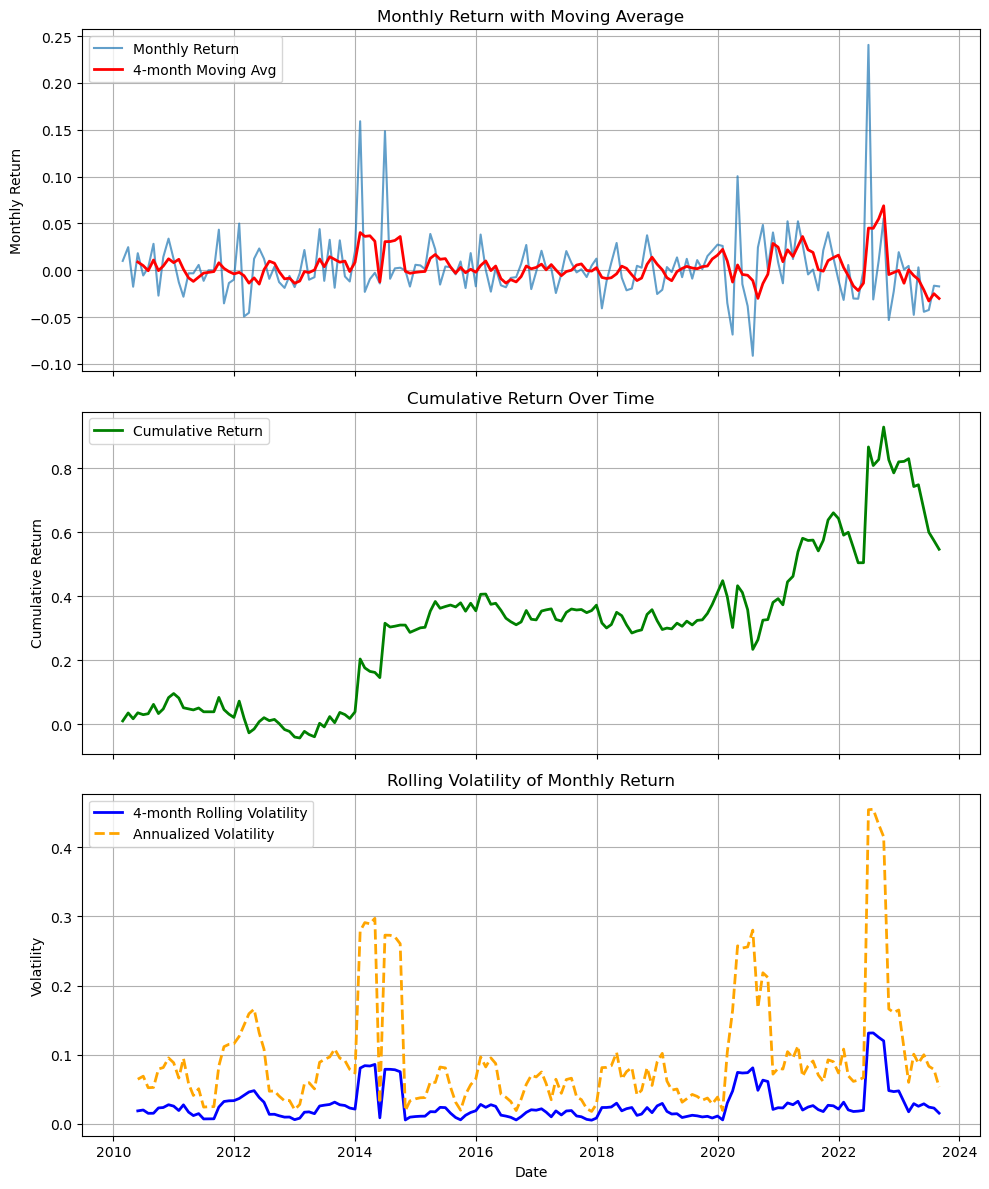

,count,mean,std,min,25%,50%,75%,max
monthly_return,163.000,0.003,0.035,-0.091,-0.014,0.001,0.014,0.241


In [471]:
plot_monthly_pnl(realised_h_strat_returns)

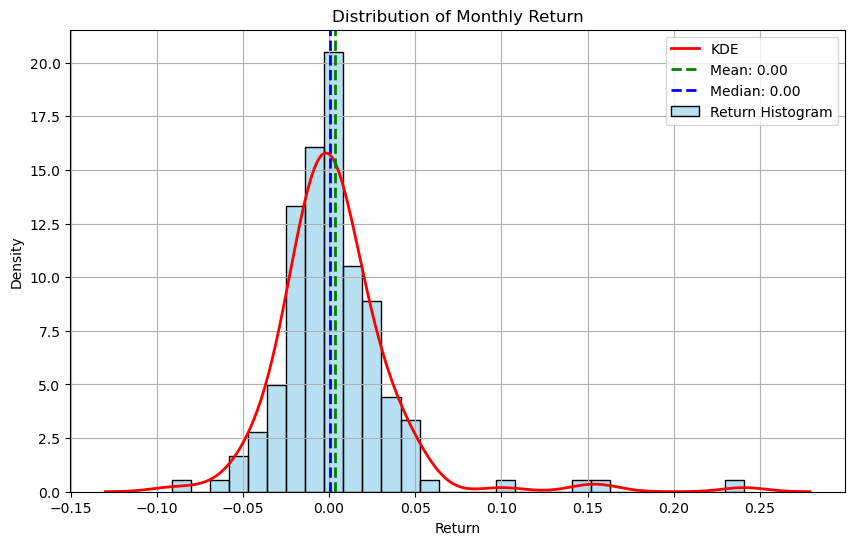

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.06,0.15,-0.06,-0.08,-0.04,-0.05,2.71,14.75


In [472]:
plot_pnl_distribution(realised_h_strat_returns)

In [473]:
calculate_performance_metrics(realised_h_strat_returns)

,Value
Average Monthly Return,0.0033
Std Monthly Return,0.0355
Annualized Sharpe Ratio,0.3194
Annualized Sortino Ratio,0.6977
Maximum Drawdown,-0.3823
Number of Periods,163.0000
Win Ratio (%),52.1472
Profit Factor,1.3577
Max Consecutive Wins,6.0000
Max Consecutive Losses,5.0000


### **Performance of portfolios sorted on implied roughness**

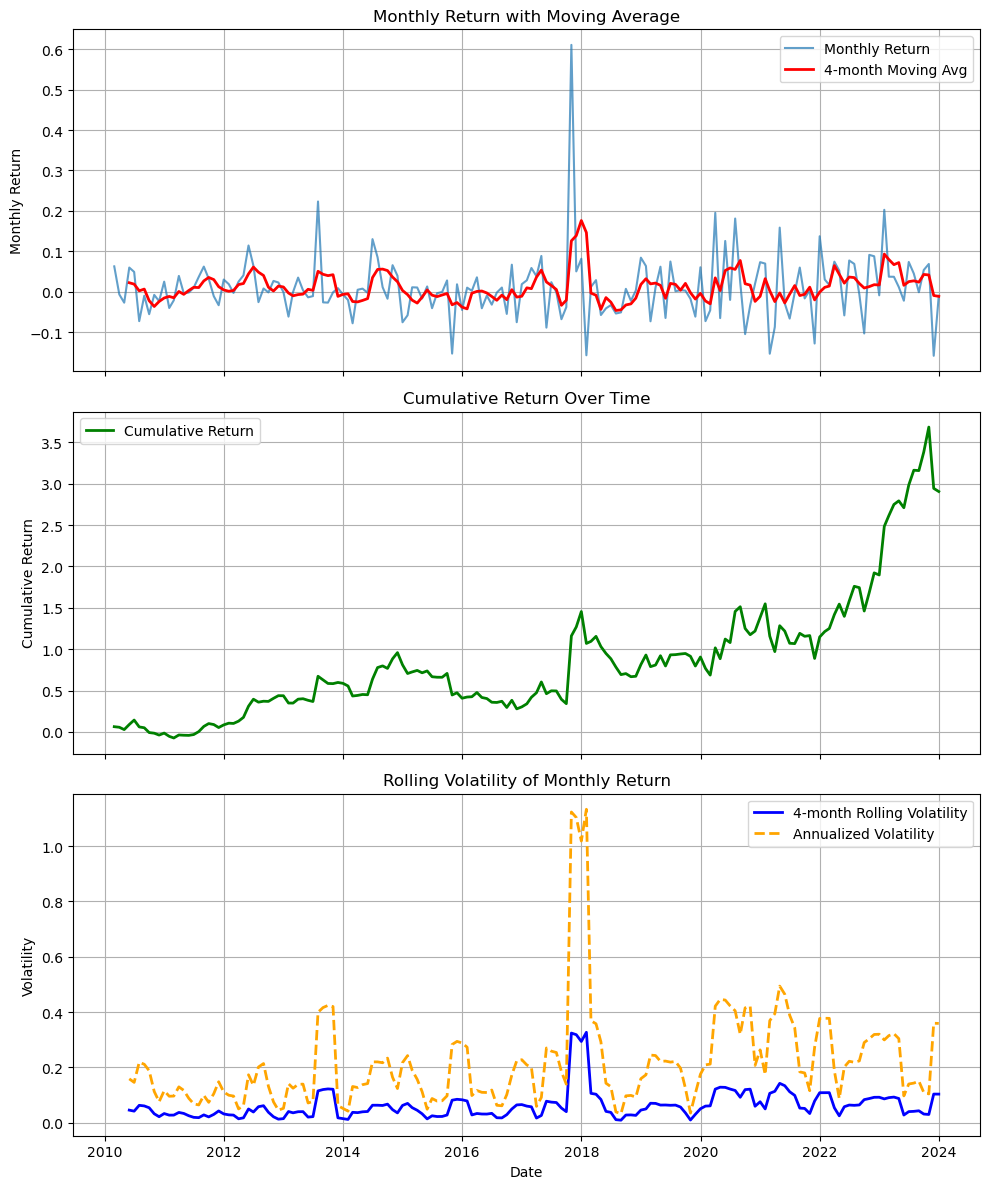

,count,mean,std,min,25%,50%,75%,max
monthly_return,167.000,0.011,0.079,-0.158,-0.026,0.004,0.039,0.611


In [474]:
plot_monthly_pnl(implied_h_strat_returns)

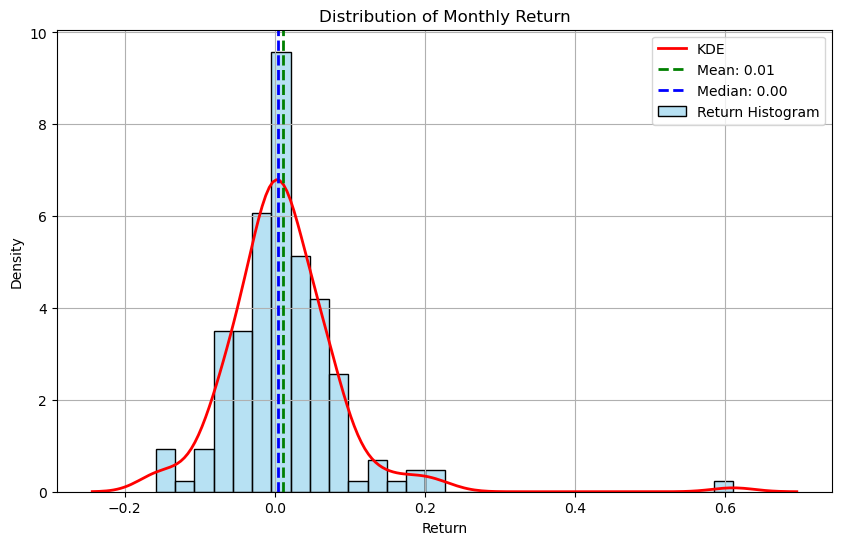

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.15,0.21,-0.15,-0.16,-0.08,-0.13,2.77,19.31


In [475]:
plot_pnl_distribution(implied_h_strat_returns)

In [476]:
calculate_performance_metrics(implied_h_strat_returns)

,Value
Average Monthly Return,0.0109
Std Monthly Return,0.0787
Annualized Sharpe Ratio,0.4817
Annualized Sortino Ratio,0.9564
Maximum Drawdown,-0.7876
Number of Periods,167.0000
Win Ratio (%),52.6946
Profit Factor,1.5662
Max Consecutive Wins,5.0000
Max Consecutive Losses,5.0000
